In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize, Minuit
print('chi2 for 1 sigma = ', chi2.isf(1-0.683, 1, loc=0, scale=1))
print('chi2 for 2 sigma = ', chi2.isf(1-0.954, 1, loc=0, scale=1))
print('chi2 for 3 sigma = ', chi2.isf(1-0.997, 1, loc=0, scale=1))

chi2 for 1 sigma =  1.0012840694690475
chi2 for 2 sigma =  3.981594462262515
chi2 for 3 sigma =  8.807468393511947


In [2]:
# Fixed the bins, colors, JSF_arr arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_mid = bins[:-1]+bins_w/2
bins_dense = np.linspace(bins_min, bins_max, 1000)

JSF_arr = [0.95, 1.0, 1.05]
JSF_dense = np.linspace(0.95, 1.05, 1000)

loglikeli_cut = -75
marginal_prob_cut = 0.2

sudo_event = 10000

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
two_gau_fit_labels = ['Mean of  first Gaussian', 'Variance of first Gaussian', 'Mean of  second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']

In [3]:
def get_reco_top_JSF_arr(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and JSF_arr from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_JSF_arr'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_JSF_arr'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_JSF_arr'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_JSF_arr']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_JSF_arr']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_JSF_arr']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_JSF_arr'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    bins_min < reco_m_top < bins_max
    additional cuts (same as CMS)
    """
    """
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
    del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
    del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
    delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
    cut_reco_top = np.logical_and(dic['reconstructed_top_JSF_arr'] > bins_min, dic['reconstructed_top_JSF_arr'] < bins_max)
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))
    """
    cuts = np.logical_and(dic['reconstructed_top_JSF_arr'] > bins_min, dic['reconstructed_top_JSF_arr'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_JSF_arr'], state, cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_JSF_arr'], state, cuts, h5py_file['spanet/right_target/assignment_probability'][:], h5py_file['spanet/right_target/detection_probability'][:], h5py_file['spanet/right_target/marginal_probability'][:]

In [4]:
# The reco_top_mss from ttbar_testing_JSF_arr_variation
# 0 for unmatched, 1 for incorrect, 2 for correct

reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, assignment_spanet_dic, detection_spanet_dic, marginal_spanet_dic = {}, {}, {}, {}

m = 173
for JSF in JSF_arr:
    h5py_file = h5py.File('ttbar_testing/ttbar_testing_{}_gev.h5'.format(m), "r")
    reco_spanet_dic[JSF], state_spanet_dic[JSF], cut_spanet_dic[JSF], assignment_spanet_dic[JSF], detection_spanet_dic[JSF], marginal_spanet_dic[JSF] = get_reco_top_JSF_arr(h5py_file, 'spanet', JSF)
    h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
    reco_klf_dic[JSF], state_klf_dic[JSF], cut_klf_dic[JSF], loglikeli_klf_dic[JSF]  = get_reco_top_JSF_arr(h5py_file, 'klfitter', JSF)

In [5]:
h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")

In [6]:
h5py_file

<HDF5 file "ttbar_testing_173_gev_with_spanet_KLFitter.h5" (mode r)>

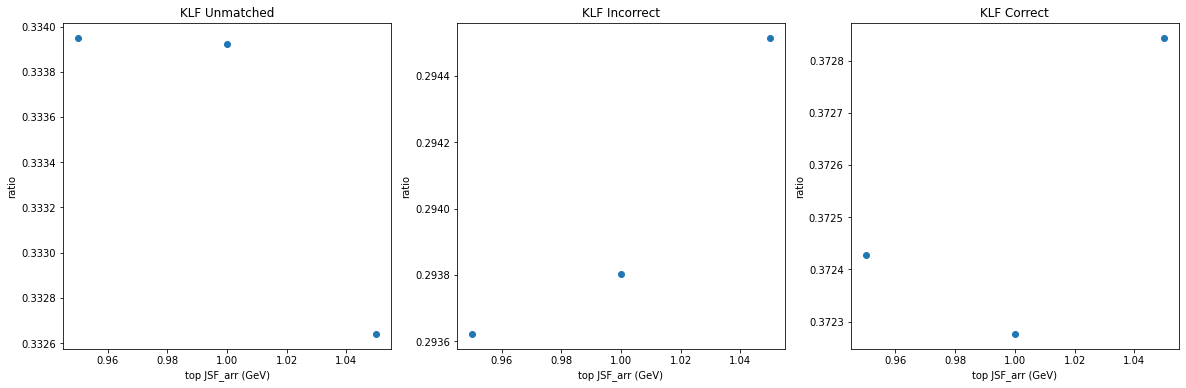

In [5]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(JSF_arr):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut)]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut)])
        ratio_klf_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(JSF_arr, ratio_klf_dic[state_i])
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top JSF_arr (GeV)')
    plt.ylabel('ratio')
plt.show()
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}

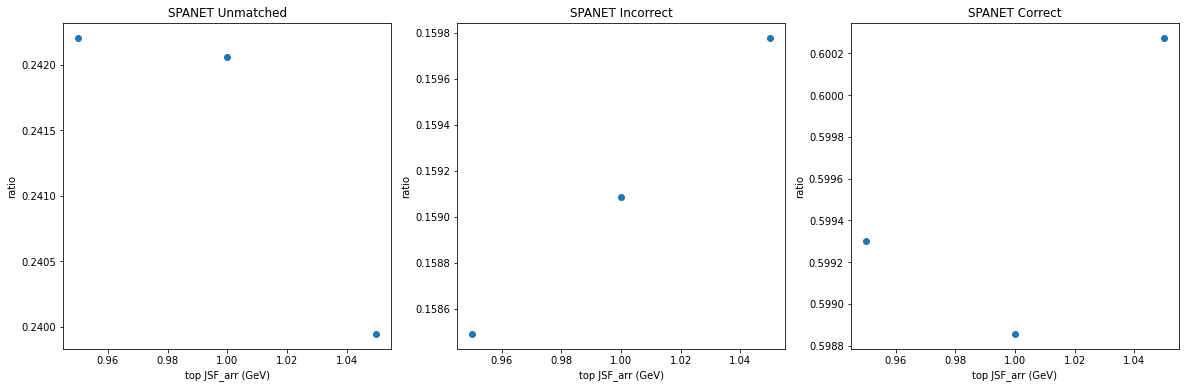

In [6]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(JSF_arr):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut)]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut)])
        ratio_spanet_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(JSF_arr, ratio_spanet_dic[state_i])
    plt.title('SPANET ' + state_labels[state_i])
    plt.xlabel('top JSF_arr (GeV)')
    plt.ylabel('ratio')
plt.show()
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}

In [7]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
# Nomalized
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Normalized between bins_min and bins_max
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, bins_min, bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

def voigt(x, shift, sigma, gamma):
    return scipy.special.voigt_profile(x - shift, sigma, gamma)

def voigt_norm(x, shift, sigma, gamma):
    return voigt(x, shift, sigma, gamma)/integrate.quad(voigt, bins_min, bins_max, args=(shift, sigma, gamma))[0]

# Linear
def linear(x, a, b):
    return a*x+b

def chi2_pdf(observed, pdf): #observed is the observation, pdf is the normalized height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

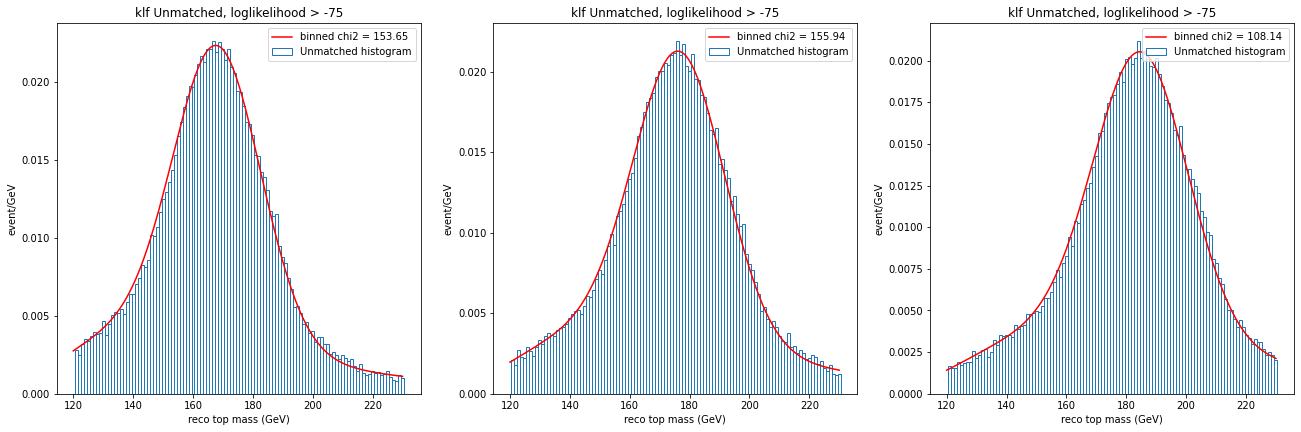

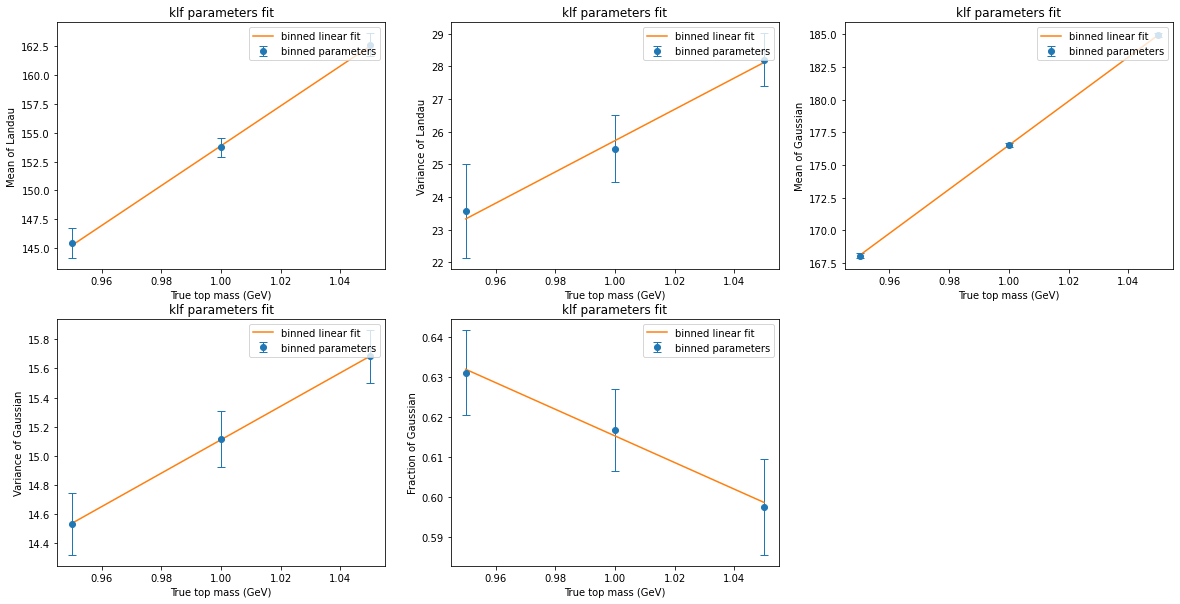

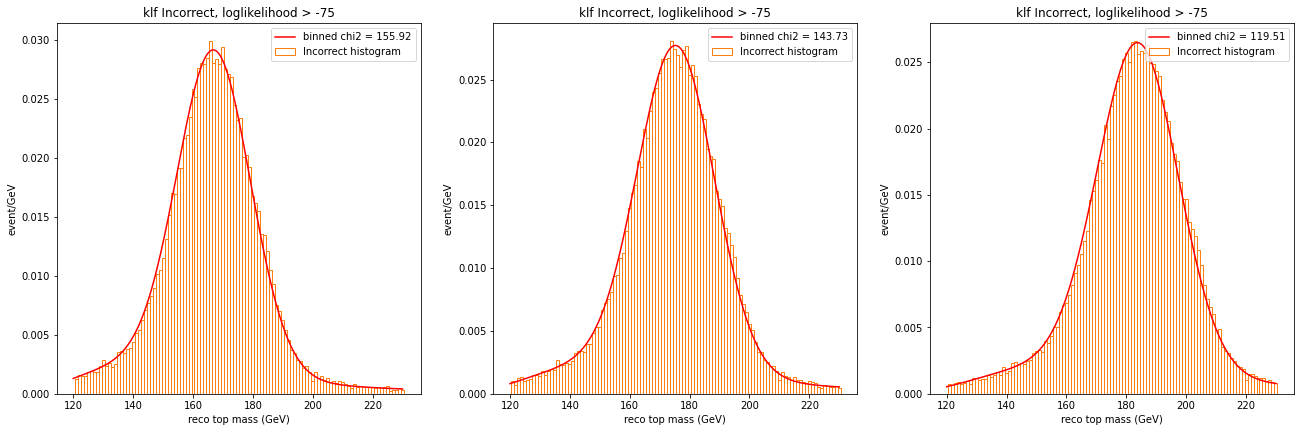

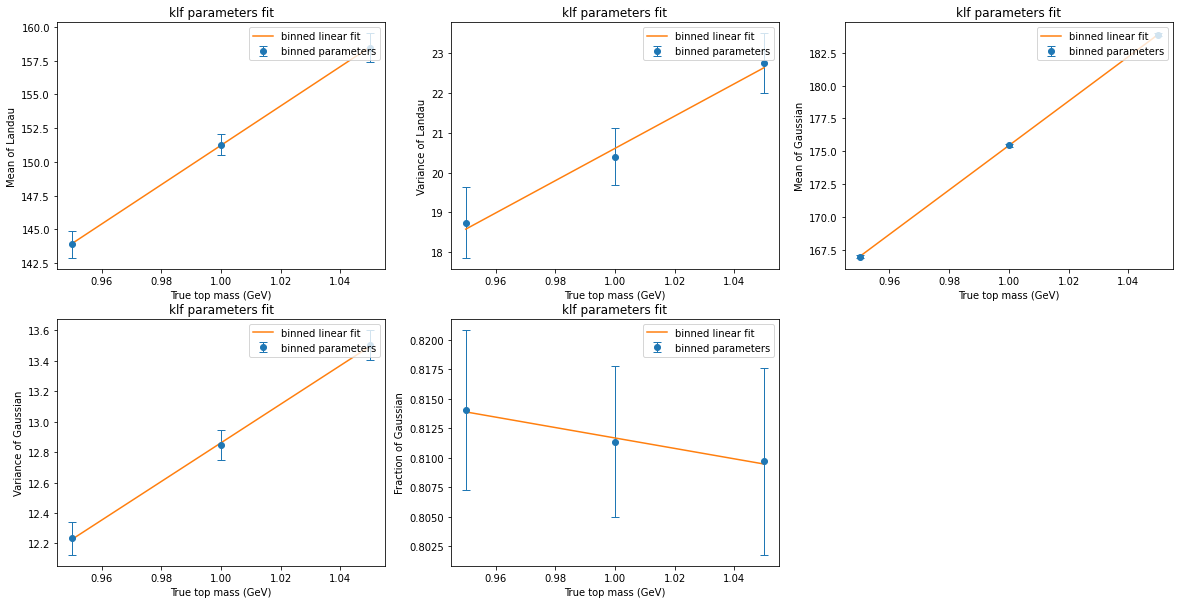

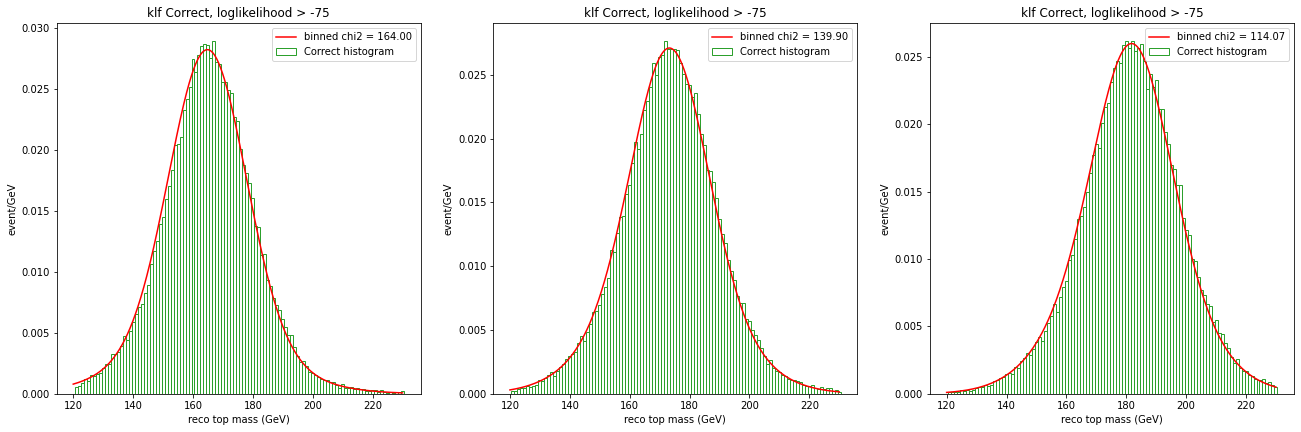

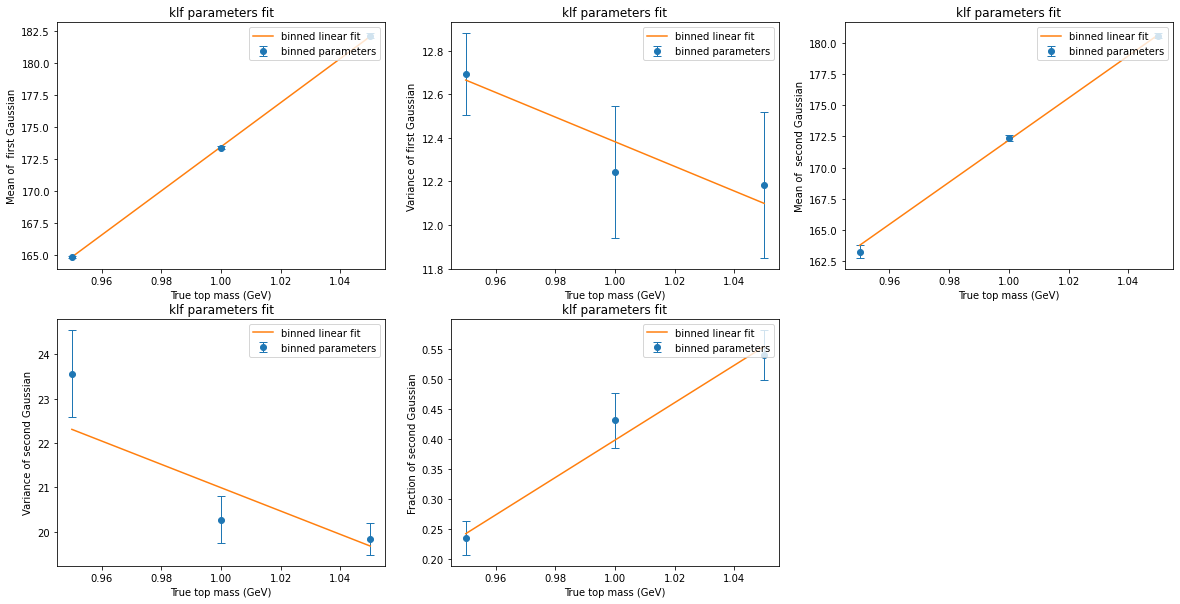

In [8]:
# Fit every class of klfitter
fita_klf_dic, fitb_klf_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_klf_arr = []
    perr_klf_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>loglikeli_cut))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
        
        # 2Gaussian for correct
        if state_i == 2:
            popt, pcov = optimize.curve_fit(two_gau_norm, bins_mid, hist, sigma=sigma, p0=(180, 10, 170, 25, 0.9), bounds=((120, 5, 140, 18, 0), (200, 18, 200, 35, 1)))
            y_dense = two_gau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, two_gau_norm(bins_mid, *popt))

        # Landau + Gaussian for incorrect and unmatch
        else:
            popt, pcov = optimize.curve_fit(langau_norm, bins_mid, hist, sigma=sigma, p0=(150, 20, 160, 20, 0.9), bounds=((120, 10, 120, 10, 0), (220, 50, 220, 30, 1)))
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))

        popt_klf_arr.append(popt)
        perr_klf_arr.append(np.sqrt(np.diag(pcov)))
        plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.title('klf {}, loglikelihood > {}'.format(state_labels[state_i], loglikeli_cut))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.show()

    popt_klf_arr = np.transpose(np.array(popt_klf_arr))
    fit_popt_dic[state_i] = popt_klf_arr
    perr_klf_arr = np.transpose(np.array(perr_klf_arr))
    fita_klf_arr, fitb_klf_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_klf_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, JSF_arr, arr, sigma=perr_klf_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(JSF_arr, arr, yerr = perr_klf_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(JSF_dense, popt[0], popt[1])
        plt.plot(JSF_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
        plt.title('klf parameters fit')
        fita_klf_arr.append(popt[0])
        fitb_klf_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.show()
    fita_klf_dic[state_i] = fita_klf_arr
    fitb_klf_dic[state_i] = fitb_klf_arr

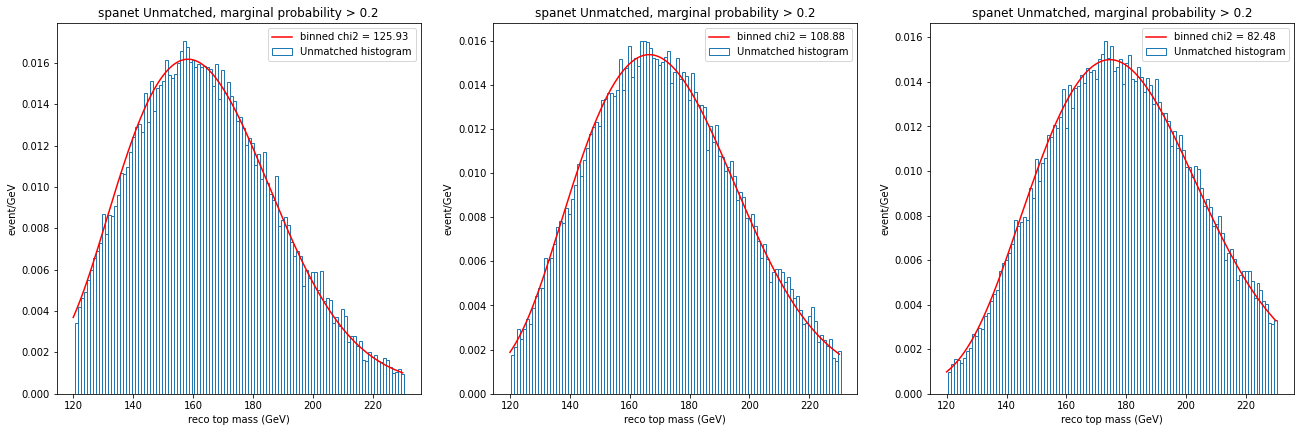

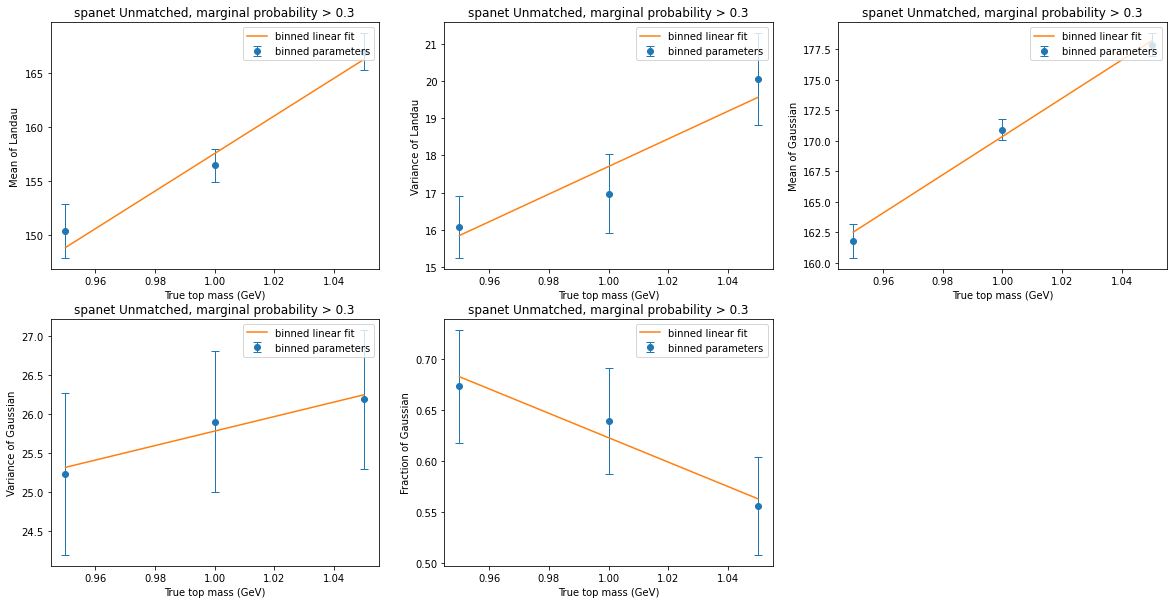

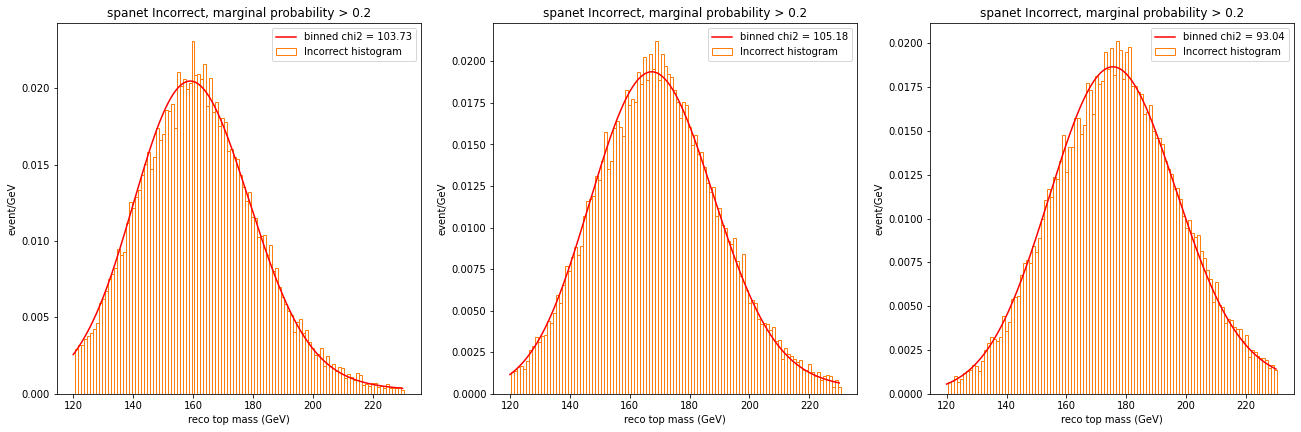

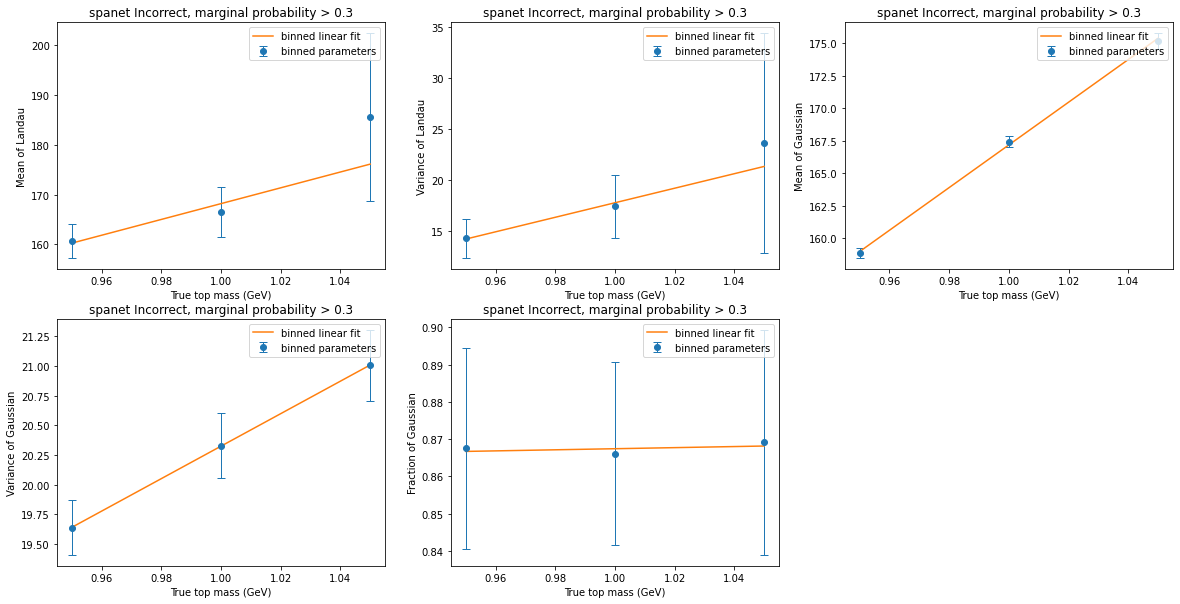

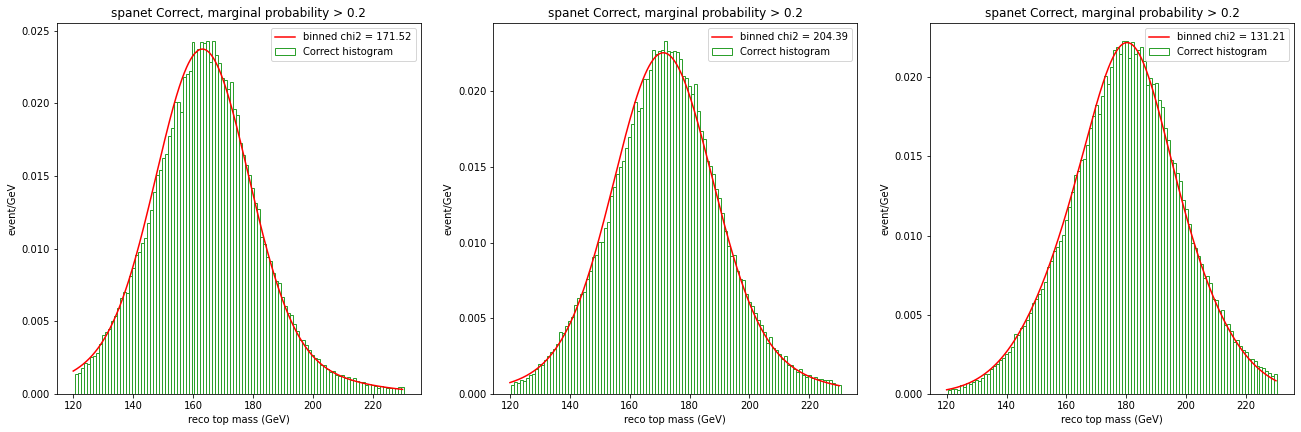

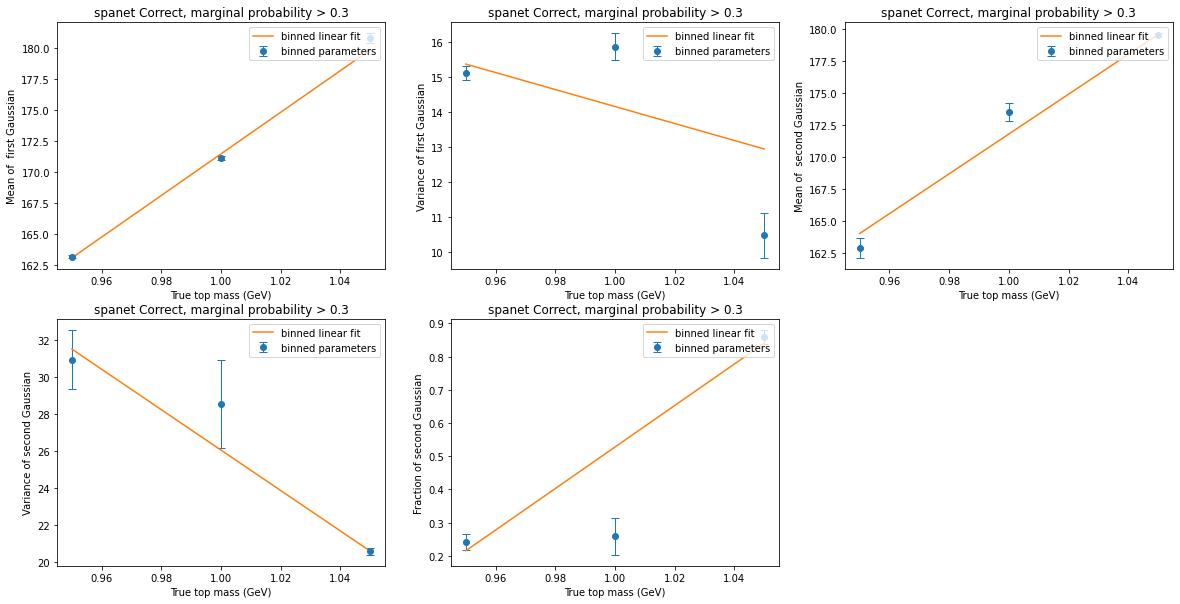

In [9]:
# Fit every class of spanet
fita_spanet_dic, fitb_spanet_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_spanet_arr = []
    perr_spanet_arr = []
    
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, marginal_spanet_dic[m]>marginal_prob_cut))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
        
        # 2Gaussian for correct
        if state_i == 2:
            popt, pcov = optimize.curve_fit(two_gau_norm, bins_mid, hist, sigma=sigma, p0=(180, 10, 170, 25, 0.9), bounds=((120, 5, 140, 18, 0), (200, 18, 200, 35, 1)))
            y_dense = two_gau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, two_gau_norm(bins_mid, *popt))

        # Landau + Gaussian for incorrect and unmatch
        else:
            popt, pcov = optimize.curve_fit(langau_norm, bins_mid, hist, sigma=sigma, p0=(150, 20, 160, 20, 0.9), bounds=((120, 10, 120, 10, 0), (220, 50, 220, 30, 1)))
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))

        popt_spanet_arr.append(popt)
        perr_spanet_arr.append(np.sqrt(np.diag(pcov)))
        plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.title('spanet {}, marginal probability > {}'.format(state_labels[state_i], marginal_prob_cut))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc = 'upper right')
    plt.show()

    popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    fit_popt_dic[state_i] = popt_spanet_arr
    perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    fita_spanet_arr, fitb_spanet_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_spanet_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, JSF_arr, arr, sigma=perr_spanet_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(JSF_arr, arr, yerr = perr_spanet_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(JSF_dense, popt[0], popt[1])
        plt.plot(JSF_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
        plt.title('spanet {}, marginal probability > 0.3'.format(state_labels[state_i]))
        fita_spanet_arr.append(popt[0])
        fitb_spanet_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.show()
    fita_spanet_dic[state_i] = fita_spanet_arr
    fitb_spanet_dic[state_i] = fitb_spanet_arr

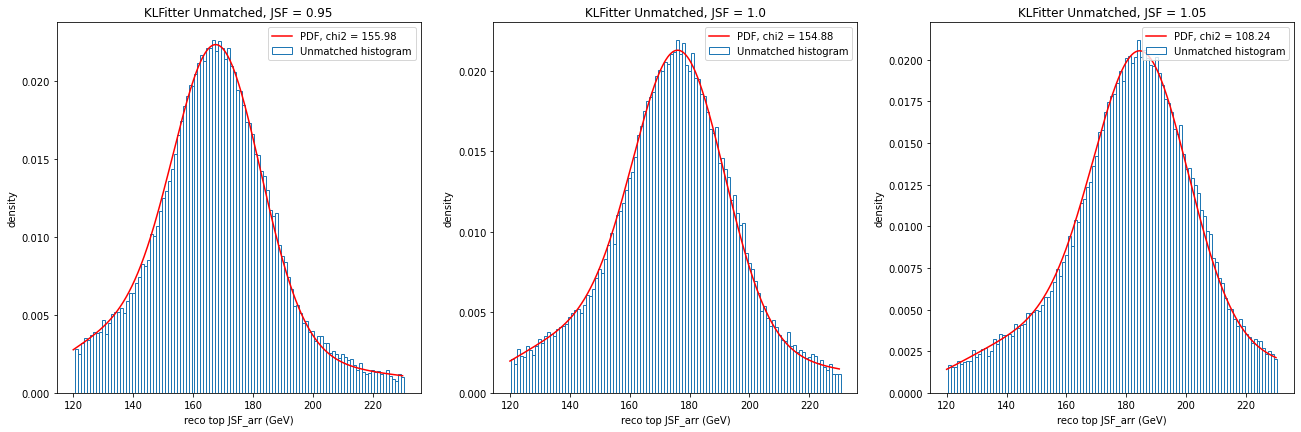

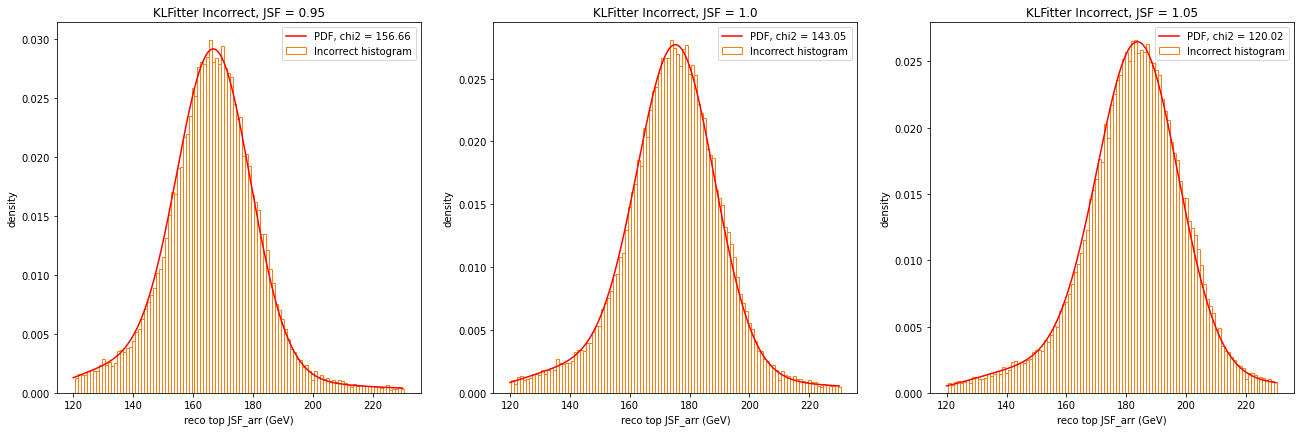

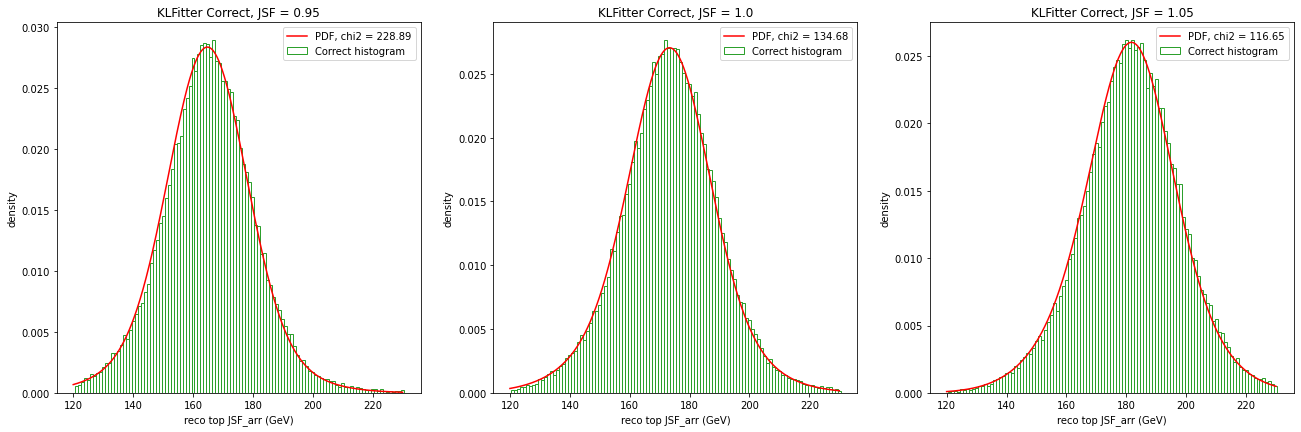

In [27]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>loglikeli_cut))]
        hist, bin_edges = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_klf_dic[state_i])*m+fitb_klf_dic[state_i]
        if state_i  == 2:
            y_template_dense_norm = two_gau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, two_gau_norm(bins_mid, *popt))
        else:
            y_template_dense_norm = langau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))

        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {}, JSF = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top JSF_arr (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

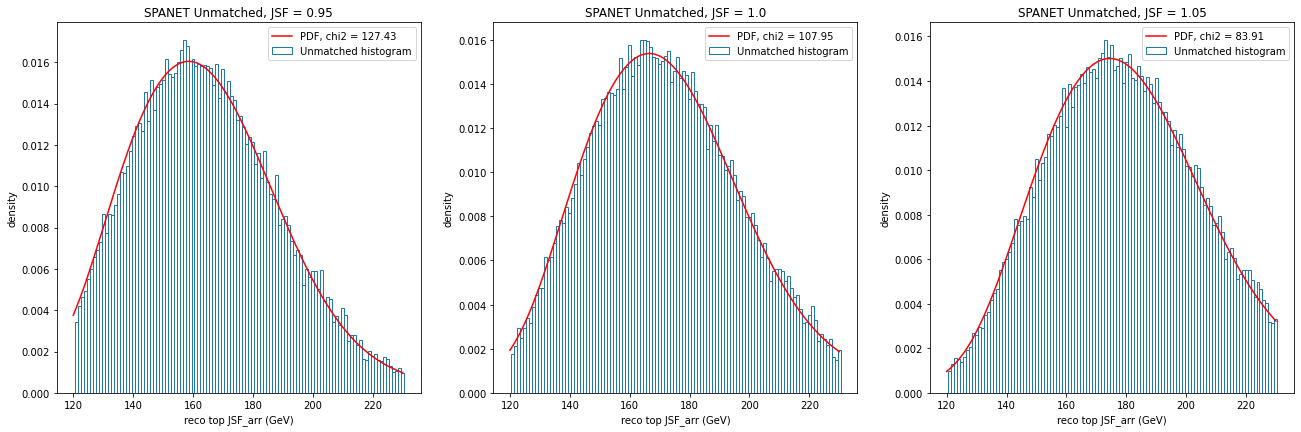

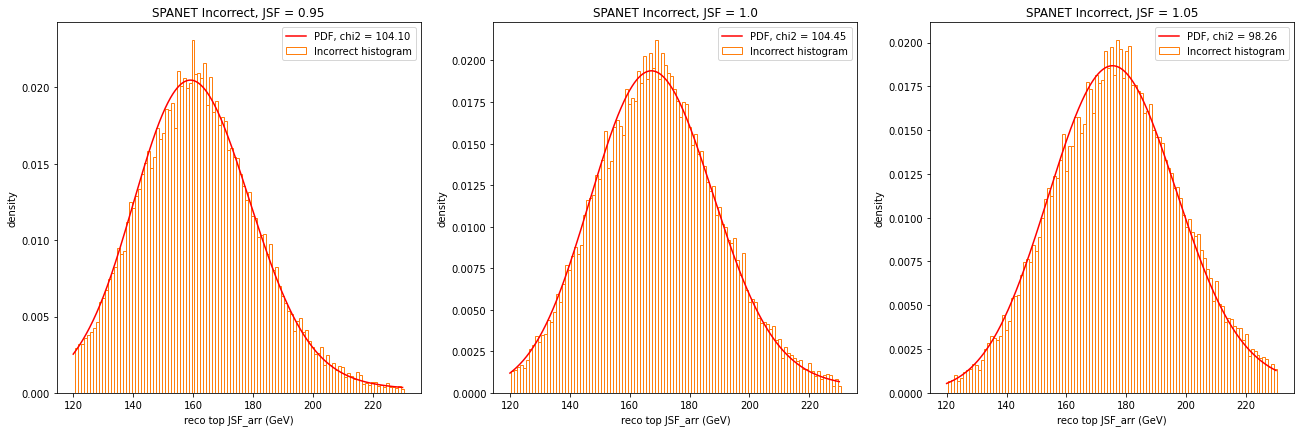

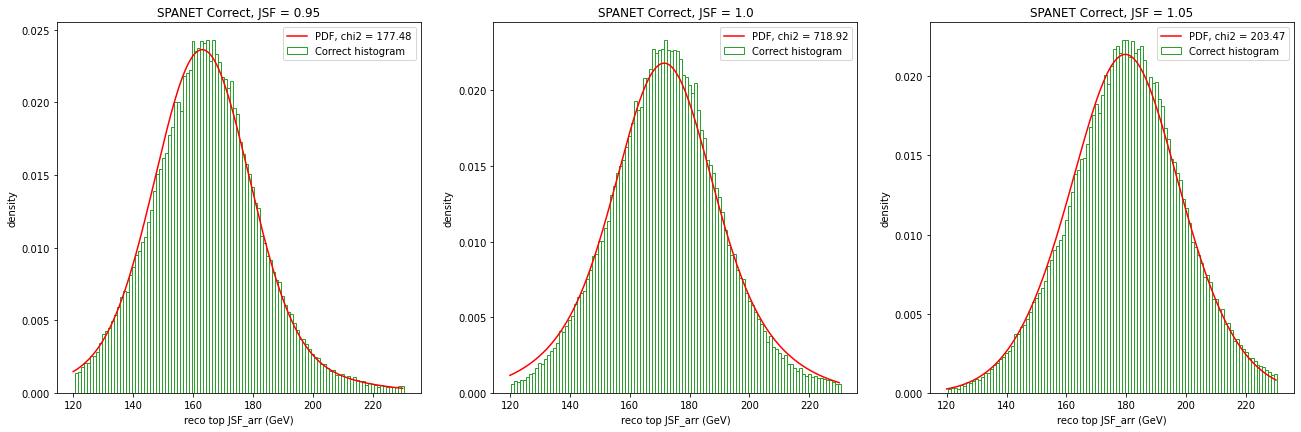

In [28]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, marginal_spanet_dic[m]>marginal_prob_cut))]
        hist, bin_edges = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
        if state_i  == 2:
            y_template_dense_norm = two_gau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, two_gau_norm(bins_mid, *popt))
        else:
            y_template_dense_norm = langau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))

        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPANET {}, JSF = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top JSF_arr (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

In [15]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_klf_dic[state_i])*m + fitb_klf_dic[state_i]
        if state_i == 2: hist += two_gau_norm(x, *popt)*ratio_klf[state_i]
        else: hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_spanet_dic[state_i])*m + fitb_spanet_dic[state_i]
        if state_i == 2: hist += two_gau_norm(x, *popt)*ratio_spanet[state_i]
        else: hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

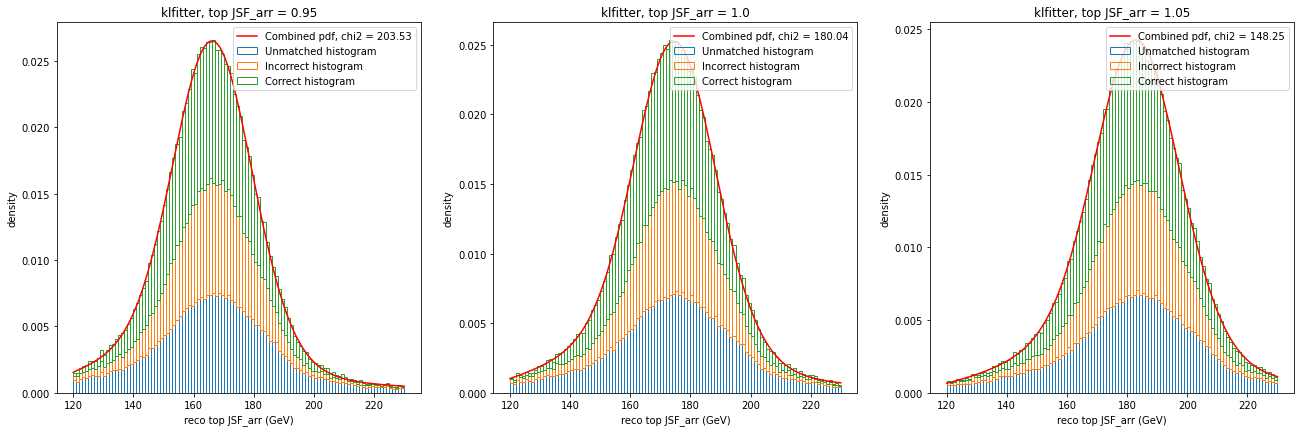

In [16]:
plt.figure(figsize=(30,15))
for i, m in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('klfitter, top JSF_arr = {}'.format(m))
    plt.xlabel('reco top JSF_arr (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

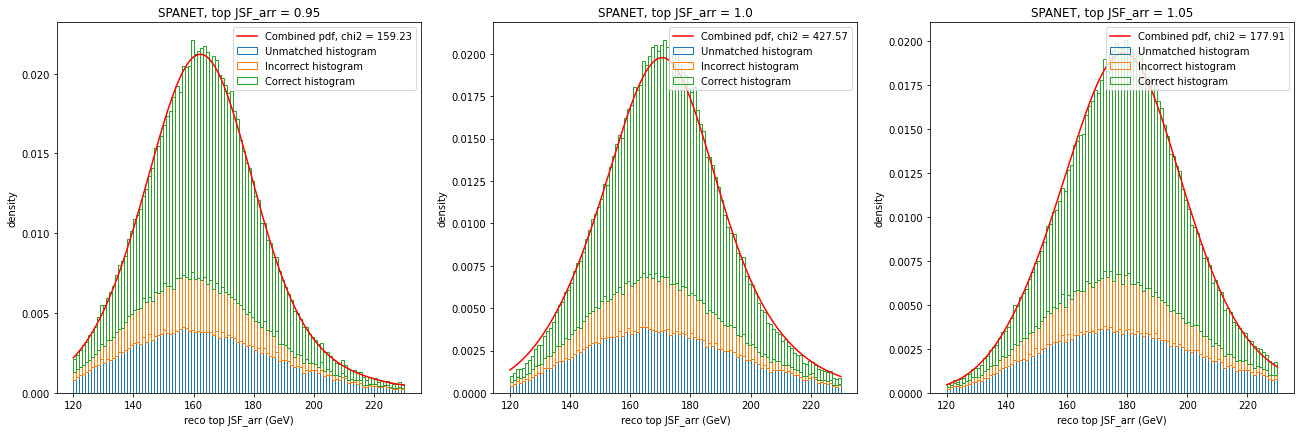

In [17]:
plt.figure(figsize=(30,15))
for i, m in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPANET, top JSF_arr = {}'.format(m))
    plt.xlabel('reco top JSF_arr (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [18]:
def chi2_klf_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_klf_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_spanet_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_spanet_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

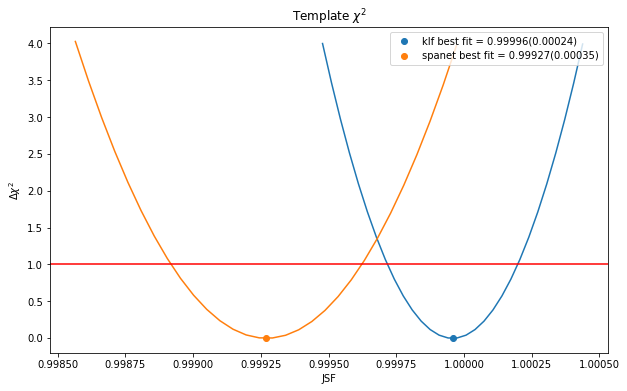

In [26]:
plt.figure(figsize=(10, 6))
m = 1
sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
n1 = np.histogram(sudo_klf, bins=bins)[0]

minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))

sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
n1 = np.histogram(sudo_spanet, bins=bins)[0]

minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='spanet best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('JSF')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
m = 1
sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
n1 = np.histogram(sudo_klf, bins=bins)[0]
n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
n1 = np.random.poisson(n1)

minuit = Minuit(chi2_klf_arr_func_n, m=m, N=np.sum(n1))
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))

sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
n1 = combine_spanet_pdf_func(bins_mid, m)*tot_event*bins_w
n1 = np.random.poisson(n1)

minuit = Minuit(chi2_spanet_arr_func_n, m=m, N=np.sum(n1))
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='spanet best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))

plt.axhline(1, c='r')
plt.title('Poisson pdf, with N, Scaled total number of event to {}'.format(tot_event))
plt.xlabel('top JSF_arr (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
m = 173
sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
n1 = combine_spanet_pdf_func(bins_mid, m)*len(sudo_spanet)*bins_w
minuit = Minuit(chi2_spanet_arr_func_n, m=m, N=np.sum(n1))
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.axhline(1, c='r')
plt.scatter(minuit.values['m'], 0, label='best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))
plt.title('Without additional cuts')
plt.xlabel('top JSF_arr (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()
print(minuit.values['N'])
print(minuit.errors['N'])

In [ ]:
#Sudo experiment for KLFitter top JSF_arr
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}

for m in JSF_arr:
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in range(sudo_event):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_klf_arr_func_n, m=m, N=np.sum(n1))
        minuit.migrad()
        minuit.hesse()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_klf_top_mean_dic[m] = mean
    sudo_klf_top_std_dic[m] = std

In [ ]:
m = 173
print(sudo_klf_top_mean_dic[m][0])
print(sudo_klf_top_std_dic[m][0])

In [ ]:
plt.errorbar(JSF_arr, [np.mean(sudo_klf_top_mean_dic[m])-m for m in JSF_arr], yerr=[np.std(sudo_klf_top_mean_dic[m])/np.sqrt(sudo_event) for m in JSF_arr])
plt.title('bias for different top JSF_arr')
plt.xlabel('top JSF_arr (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

In [ ]:
plt.figure(figsize = (6, 6))

klf_top_bias = np.mean([np.mean(sudo_klf_top_mean_dic[m])-m for m in JSF_arr])
klf_top_pull = [(np.array(sudo_klf_top_mean_dic[m])-m-klf_top_bias)/sudo_klf_top_std_dic[m] for m in JSF_arr]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter top JSF_arr pull histogram')
plt.xlim(-10, 10)
plt.xlabel('top JSF_arr pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Sudo experiment for KLFitter top JSF_arr
sudo_klf_top_pdf_mean_dic = {}
sudo_klf_top_pdf_std_dic = {}

for m in JSF_arr:
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    sudo_klf_pdf = combine_klf_pdf_func(bins_mid, m)*len(sudo_klf)*bins_w
    n1_arr = np.random.poisson(combine_klf_pdf_func(bins_mid, m)*len(sudo_klf)*bins_w, size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in range(sudo_event):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_klf_arr_func_n, m=m, N=np.sum(n1))
        minuit.migrad()
        minuit.hesse()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_klf_top_pdf_mean_dic[m] = mean
    sudo_klf_top_pdf_std_dic[m] = std

In [ ]:
plt.figure(figsize = (6, 6))

klf_top_bias = np.mean([np.mean(sudo_klf_top_pdf_mean_dic[m])-m for m in JSF_arr])
klf_top_pull = [(np.array(sudo_klf_top_pdf_mean_dic[m])-m-klf_top_bias)/sudo_klf_top_pdf_std_dic[m] for m in JSF_arr]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter top JSF_arr pull histogram (sudo from pdf)')
plt.xlim(-5, 5)
plt.xlabel('top JSF_arr pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()